<a href="https://colab.research.google.com/github/BoyHardy/lotr-character-clustering/blob/main/notebooks/Public_dataset_LOTR_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character clustering in The Lord of the Rings: K-means

Source data: https://www.kaggle.com/datasets/paultimothymooney/lord-of-the-rings-data/data?select=lotr_scripts.csv

This project aims to objectively group characters from The Lord of the Rings trilogy into main archetypes, using the number of words said in 'The Fellowship of the Ring', 'The Two Towers', 'The Return of the King' and the average sentiment of their dialogue.

## Loading the data & libraries

The first step involved finding and downloading the data from Kaggle then uploading into Google collab and importing all the required Python libraries.

In [1]:
# Importing the data

import pandas as pd
import re
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.cluster import KMeans

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

df = pd.read_excel('lotr_scripts.xlsx')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 11.8 MB/s eta 0:00:00


## Tidying the data - Blanks and Duplicates

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390 entries, 0 to 2389
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2390 non-null   int64 
 1   char        2390 non-null   object
 2   dialog      2386 non-null   object
 3   movie       2390 non-null   object
dtypes: int64(1), object(3)
memory usage: 74.8+ KB


In [3]:
# Viewing the 4 empty 'Dialog' fields to decide what to do with them - can they be removed?
df[df['dialog'].isnull()]

,Unnamed: 0,char,dialog,movie
1009,1009,EOWYN,NaN,The Two Towers
1401,1401,STRIDER,NaN,The Fellowship of the Ring
1569,1569,GIMLI,NaN,The Fellowship of the Ring
2082,2082,TREEBEARD,NaN,The Two Towers


In [4]:
# Decided they can and so can the 'Unnamed: 0' column which appears to just be the index
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset=['dialog'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2386 entries, 0 to 2389
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   char    2386 non-null   object
 1   dialog  2386 non-null   object
 2   movie   2386 non-null   object
dtypes: object(3)
memory usage: 74.6+ KB


In [5]:
# Checking for duplicate entries

print(df.duplicated().sum())

26


I chose to explore these duplicated rows from the source data in Excel. It looks like the duplicate rows are largely characters saying another characters name and common phrases, 'Yes', 'Please', 'Thank you'.

It wouldn't appear these are actual duplicates (supported by the row having a unique index). Kept them in

## Data Transformation - Character Names

Assessing the quality of the 'Character names' column

In [6]:
# To tidy up the data, I want to see a unique list of character names, checking for formatting and spelling etc
unique_characters = df['char'].unique()

# Sorting the list alphabetically makes it easier to view
sorted_unique_characters = sorted(str(name) for name in unique_characters)

# Getting a count of unique names
unique_count = len(unique_characters)

print(f"There are {unique_count} unique characters before cleaning;\n")
print(sorted_unique_characters)


There are 113 unique characters before cleaning;

['(GOLLUM', 'ARAGORN', 'ARGORN', 'ARMY', 'ARWEN', 'ARWEN VOICEOVER', 'BARLIMAN', 'BILBO', 'BILBO VOICEOVER', 'BOROMIR', 'BOSON', 'CAPTAIN', 'CHILDREN HOBBITS', 'CROWD', 'DAMROD', 'DEAGOL', 'DENETHOR', 'ELROND', 'ELROND VOICEOVER', 'EOMER', 'EOTHAIN', 'EOWYN', 'EOWYN/MERRY', 'EYE OF SAURON', 'FARAMIR', 'FARMER MAGGOT', 'FIGWIT', 'FREDA', 'FRODO', 'FRODO VOICE', 'FRODO VOICE OVER', 'GAFFER', 'GALADRIEL', 'GALADRIEL VOICE OVER', 'GALADRIEL VOICE-OVER', 'GALADRIEL VOICEOVER', 'GALADRIL', 'GAMLING', 'GAN DALF', 'GANDALF', 'GANDALF VOICE OVER', 'GANDALF VOICEOVER', 'GATEKEEPER', 'GATEKEEPR', 'GENERAL', 'GENERAL SHOUT', 'GIMLI', 'GOLLUM', 'GORBAG', 'GOTHMOG', 'GRIMA', 'GRIMBOLD', 'GRISHNAK', 'GRISHNAKH', 'HALDIR', 'HAMA', 'HOBBIT', 'IROLAS', 'KING OF THE DEAD', 'LADY', 'LEGOLAS', 'MADRIL', 'MAN', 'MEN', 'MERCENARY', 'MERRY', 'MERRY AND PIPPIN', 'MERRY and PIPPIN', 'MORWEN', 'MOUTH OF SAURON', 'MRS BRACEGIRDLE', 'NOAKES', 'OLD MAN', 'ORC', 'ORC

In [7]:
# Created a name map to ensure names are consistently applied (this did involve research of the script to make sure lines
# said by more than 1 person at once (eg 'Merry & Pippin') are allocated correctly)

#Standardise format
df['char'] = df['char'].astype(str).str.upper()

#Create name map
name_map = {
    #Aragorn
'ARGORN' : 'ARAGORN',
'STRIDER' : 'ARAGORN',

    #Arwen
'ARWEN VOICEOVER' : 'ARWEN',

    #Bilbo
'BILBO VOICEOVER' : 'BILBO',

    #Elrond
'ELROND VOICEOVER' : 'ELROND',

    #Eowyn
'EOWYN/MERRY' : 'EOWYN',

    #Frodo
'FRODO VOICE OVER' : 'FRODO',
'FRODO VOICE' : 'FRODO',

    #Galadriel
'GALADRIEL VOICE OVER' : 'GALADRIEL',
'GALADRIEL VOICE-OVER' : 'GALADRIEL',
'GALADRIEL VOICEOVER' : 'GALADRIEL',
'GALADRIL' : 'GALADRIEL',

    #Gandalf
'GAN DALF' : 'GANDALF',
'GANDALF VOICEOVER' : 'GANDALF',
'GANDALF VOICE OVER' : 'GANDALF',
'\xa0GANDALF' : 'GANDALF',
'WHITE WIZARD' : 'GANDALF',

    #Gatekeeper
'GATEKEEPR' : 'GATEKEEPER',

    #Gollum
'(GOLLUM' : 'GOLLUM',

    #Grishnak
'GRISHNAKH' : 'GRISHNAK',

    #Hobbit
'VOICE' : 'HOBBIT',

    #Orc
'CAPTAIN' : 'ORC',
'GENERAL' : 'ORC',

    #Sauron
'EYE OF SAURON' : 'SAURON',
'RING' : 'SAURON',
'SAURON VOICE' : 'SAURON',

    #Sam
'SAM VOICEOVER' : 'SAM',

    #Saruman
'SARUMAN VOICE OVER' : 'SARUMAN',
'SARUMAN VOICEOVER' : 'SARUMAN',

    #Soldier
'SOLDIER 1' : 'SOLDIER',
'SOLDIER 2' : 'SOLDIER',
'SOLDIERS IN MINAS TIRITH' : 'SOLDIER',
'SOLDIERS ON GATE': 'SOLDIER',

    #Uruk-Hai
'URUK HAI' : 'URUK-HAI',
}

df['char'] = df['char'].replace(name_map)

In [8]:
# Repeat step to check the mapping has successfully applied
unique_characters = df['char'].unique()
sorted_unique_characters = sorted(str(name) for name in unique_characters)

unique_count = len(unique_characters)

print(f"There are {unique_count} unique characters after cleaning;\n")
print(sorted_unique_characters)


There are 78 unique characters after cleaning;

['ARAGORN', 'ARMY', 'ARWEN', 'BARLIMAN', 'BILBO', 'BOROMIR', 'BOSON', 'CHILDREN HOBBITS', 'CROWD', 'DAMROD', 'DEAGOL', 'DENETHOR', 'ELROND', 'EOMER', 'EOTHAIN', 'EOWYN', 'FARAMIR', 'FARMER MAGGOT', 'FIGWIT', 'FREDA', 'FRODO', 'GAFFER', 'GALADRIEL', 'GAMLING', 'GANDALF', 'GATEKEEPER', 'GENERAL SHOUT', 'GIMLI', 'GOLLUM', 'GORBAG', 'GOTHMOG', 'GRIMA', 'GRIMBOLD', 'GRISHNAK', 'HALDIR', 'HAMA', 'HOBBIT', 'IROLAS', 'KING OF THE DEAD', 'LADY', 'LEGOLAS', 'MADRIL', 'MAN', 'MEN', 'MERCENARY', 'MERRY', 'MERRY AND PIPPIN', 'MORWEN', 'MOUTH OF SAURON', 'MRS BRACEGIRDLE', 'NOAKES', 'OLD MAN', 'ORC', 'ORCS', 'PEOPLE', 'PIPPIN', 'PROUDFOOT HOBBIT', 'ROHAN HORSEMAN', 'ROHAN STABLEMAN', 'ROHIRRIM', 'ROSIE', 'SAM', 'SANDYMAN', 'SARUMAN', 'SAURON', 'SHAGRAT', 'SHARKU', 'SMEAGOL', 'SNAGA', 'SOLDIER', 'SOLDIERS', 'THEODEN', 'TREEBEARD', 'UGLUK', 'URUK-HAI', 'WILDMAN', 'WITCH KING', 'WOMAN']


In [9]:
# Need to drop 'non-character entities eg: Army, Men, Hobbits etc. Opting for non-destructive filtering to keep original dataframe unaffected (just in case!!)
# Basis of removing plural names eg: Hobbit, Man, Lady as these can't be allocated to individual characters

generic_names_to_drop = [
    'ARMY',
    'CHILDREN HOBBITS',
    'CROWD'
    'GENERAL SHOUT',
    'HOBBIT',
    'MAN',
    'LADY',
    'MEN',
    'MERCENARY',
    'ORCS',
    'PEOPLE',
    'ROHIRRIM',
    'SOLDIERS',
    'URUK-HAI',
    'WOMAN'
]

df_use = df[ ~df['char'].isin(generic_names_to_drop)]

# check the new df
filtered_unique_char = df_use['char'].unique()
print(filtered_unique_char)


['DEAGOL' 'SMEAGOL' 'GOLLUM' 'FRODO' 'MERRY' 'GIMLI' 'SAM' 'GANDALF'
 'ARAGORN' 'PIPPIN' 'ROSIE' 'BILBO' 'TREEBEARD' 'SARUMAN' 'THEODEN'
 'GALADRIEL' 'ELROND' 'GRIMA' 'WITCH KING' 'EOWYN' 'FARAMIR' 'ORC'
 'SOLDIER' 'GOTHMOG' 'MOUTH OF SAURON' 'EOMER' 'BOSON' 'DENETHOR'
 'LEGOLAS' 'KING OF THE DEAD' 'GRIMBOLD' 'IROLAS' 'GAMLING' 'MADRIL'
 'DAMROD' 'HALDIR' 'OLD MAN' 'BOROMIR' 'CROWD' 'ARWEN' 'HAMA' 'SHARKU'
 'FREDA' 'MORWEN' 'SAURON' 'ROHAN STABLEMAN' 'GORBAG' 'UGLUK' 'SHAGRAT'
 'SNAGA' 'GRISHNAK' 'MERRY AND PIPPIN' 'WILDMAN' 'EOTHAIN'
 'ROHAN HORSEMAN' 'FARMER MAGGOT' 'GAFFER' 'NOAKES' 'SANDYMAN' 'FIGWIT'
 'GENERAL SHOUT' 'MRS BRACEGIRDLE' 'PROUDFOOT HOBBIT' 'GATEKEEPER'
 'BARLIMAN']


## Data Transformation - The Dialogue

In [10]:
# Created a function to clean the dialogue

def clean_text(text):
  text = str(text).lower() # Convert all words to lower case
  text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Removing 'punctuation'
  text = re.sub(r'\s+', ' ', text) # Reformats any double spaces, tabs etc as a single space to format the data correctly
  text = text.strip() # Removes any spaces at the start or end of the string
  return text

df_use['dialog_clean'] = df_use['dialog'].apply(clean_text) # Apply the function to the 'dialog' column

df_use.head(50) # Display the first 50 rows to get a view of the data

/tmp/ipython-input-2687084478.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['dialog_clean'] = df_use['dialog'].apply(clean_text) # Apply the function to the 'dialog' column


,char,dialog,movie,dialog_clean
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King,oh smeagol ive got one ive got a fish smeagol ...
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King,pull it in go on go on go on pull it in
2,DEAGOL,Arrghh!,The Return of the King,arrghh
3,SMEAGOL,Deagol!,The Return of the King,deagol
4,SMEAGOL,Deagol!,The Return of the King,deagol
5,SMEAGOL,Deagol!,The Return of the King,deagol
6,SMEAGOL,Give us that! Deagol my love,The Return of the King,give us that deagol my love
7,DEAGOL,Why?,The Return of the King,why
8,SMEAGOL,"Because' , it's my birthday and I wants it.",The Return of the King,because its my birthday and i wants it
9,SMEAGOL,My precious.,The Return of the King,my precious


## Prep for modelling - word counts

In [11]:
# Adding the number of words per line

df_use['word_count'] = df_use['dialog_clean'].apply(lambda x: len(x.split()))

df_use.head(50)

/tmp/ipython-input-3447077004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['word_count'] = df_use['dialog_clean'].apply(lambda x: len(x.split()))


,char,dialog,movie,dialog_clean,word_count
0,DEAGOL,"Oh Smeagol Ive got one! , Ive got a fish Smeag...",The Return of the King,oh smeagol ive got one ive got a fish smeagol ...,11
1,SMEAGOL,"Pull it in! Go on, go on, go on, pull it in!",The Return of the King,pull it in go on go on go on pull it in,12
2,DEAGOL,Arrghh!,The Return of the King,arrghh,1
3,SMEAGOL,Deagol!,The Return of the King,deagol,1
4,SMEAGOL,Deagol!,The Return of the King,deagol,1
5,SMEAGOL,Deagol!,The Return of the King,deagol,1
6,SMEAGOL,Give us that! Deagol my love,The Return of the King,give us that deagol my love,6
7,DEAGOL,Why?,The Return of the King,why,1
8,SMEAGOL,"Because' , it's my birthday and I wants it.",The Return of the King,because its my birthday and i wants it,8
9,SMEAGOL,My precious.,The Return of the King,my precious,2


## Prep for modelling - adding sentiment analysis


In [12]:
# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# Define the sentiment function
def sentiment_score(text):
  return analyzer.polarity_scores(str(text))['compound']

# Apply
df_use.loc[:, 'sentiment'] = df_use['dialog'].apply(sentiment_score)

# Aggregate by character
char_sentiment_analysis = df_use.groupby('char').agg(
    avg_sentiment = ('sentiment', 'mean'),
    total_words = ('word_count', 'sum')
)

# Filter to just those with >30 words ('30 words' limit identified in an EDA step below)
filtered_sentiment_analysis = char_sentiment_analysis[char_sentiment_analysis['total_words'] > 30].sort_values(by='avg_sentiment')

print(filtered_sentiment_analysis)

                  avg_sentiment  total_words
char                                        
KING OF THE DEAD      -0.281488           66
GOTHMOG               -0.214457           93
GRIMA                 -0.184088          376
MADRIL                -0.177600          138
UGLUK                 -0.132744           63
ELROND                -0.114126          636
DENETHOR              -0.090542          803
EOMER                 -0.078444          406
MORWEN                -0.068000           35
SARUMAN               -0.065037          662
LEGOLAS               -0.063869          479
SAURON                -0.062900           32
HALDIR                -0.059986           53
WITCH KING            -0.053238           67
GALADRIEL             -0.032042          556
BOROMIR               -0.021285          474
SAM                   -0.019942         2115
THEODEN               -0.014008         1208
SOLDIER               -0.007055          186
FARAMIR               -0.005706          808
GANDALF   

/tmp/ipython-input-632789832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use.loc[:, 'sentiment'] = df_use['dialog'].apply(sentiment_score)


## Exploratory Data Analysis (EDA)

### Word Clouds

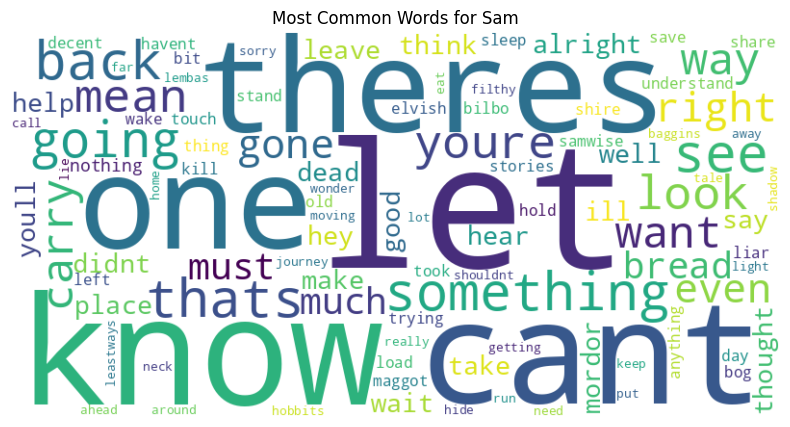

In [13]:
# Creating word clouds to see characters most common words

sam_dialog = " ".join(df_use[df_use['char'] == 'SAM']['dialog_clean']) # Word cloud tool cant read a df, requires 1 long string so filters down to Sam, then joins all clean dialog into 1 string

# Define stopwords (words to ignore such as names, common filler words, numbers etc)
my_stopwords = set(STOPWORDS)
my_stopwords.update([
    'frodo', 'mr', 'gandalf', 'sam', 'aragorn', 'pippin', 'merry', 'gollum', 'strider', 'samwise,' # Character names
    'one', 'ring', 'will', 'now', 'dont', 'get', 'go', 'im', 'ive', 'ill' # Common filler words
    'well', 'us', 'oh', 'yes', 'no', 'come', 'hes', 'got', # More filler
    'two', 'three', 'four', 'five', 'six', 'seven', 'eight' # numbers
])

# Generate the word cloud object
sam_wc = WordCloud(
    stopwords=my_stopwords,
    background_color='white',
    width=800,
    height=400,
    max_words=100 # Show the top 100 words
).generate(sam_dialog)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(sam_wc, interpolation='bilinear')
plt.axis('off') # Hide the X and Y axes
plt.title('Most Common Words for Sam')
plt.show()

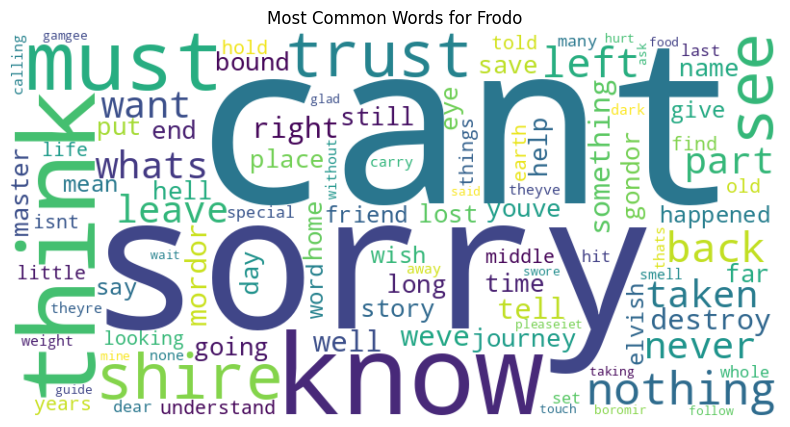

In [14]:
frodo_dialog = " ".join(df_use[df_use['char'] == 'FRODO']['dialog_clean'])

# Define stopwords (words to ignore)
my_stopwords = set(STOPWORDS)
my_stopwords.update([
    'frodo', 'mr', 'gandalf', 'sam', 'aragorn', 'pippin', 'merry', 'gollum', 'strider', 'samwise', 'smeagol', 'bilbo', # Character names
    'one', 'ring', 'will', 'now', 'dont', 'get', 'go', 'im', 'ive', 'ill' # Common filler words
    'well', 'us', 'oh', 'yes', 'no', 'come', 'hes', 'got', 'theres', # More filler
    'two', 'three', 'four', 'five', 'six', 'seven', 'eight' # numbers
])

# Generate the word cloud object
frodo_wc = WordCloud(
    stopwords=my_stopwords,
    background_color='white',
    width=800,
    height=400,
    max_words=100 # Show the top 100 words
).generate(frodo_dialog)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(frodo_wc, interpolation='bilinear')
plt.axis('off') # Hide the X and Y axes
plt.title('Most Common Words for Frodo')
plt.show()

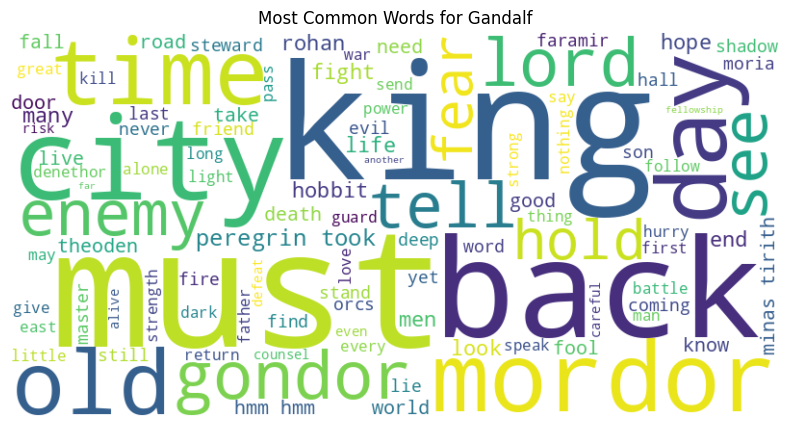

In [15]:
gandalf_dialog = " ".join(df_use[df_use['char'] == 'GANDALF']['dialog_clean'])

# Define stopwords (words to ignore)
my_stopwords = set(STOPWORDS)
my_stopwords.update([
    'frodo', 'mr', 'gandalf', 'sam', 'aragorn', 'pippin', 'merry', 'gollum', 'strider', 'samwise', 'smeagol', 'bilbo', 'sauron', 'saruman', # Character names
    'one', 'ring', 'will', 'now', 'dont', 'get', 'go', 'im', 'ive', 'ill' # Common filler words
    'well', 'us', 'oh', 'yes', 'no', 'come', 'hes', 'got', 'theres', # More filler
    'two', 'three', 'four', 'five', 'six', 'seven', 'eight' # numbers
])

# Generate the word cloud object
gandalf_wc = WordCloud(
    stopwords=my_stopwords,
    background_color='white',
    width=800,
    height=400,
    max_words=100 # Show the top 100 words
).generate(gandalf_dialog)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(gandalf_wc, interpolation='bilinear')
plt.axis('off') # Hide the X and Y axes
plt.title('Most Common Words for Gandalf')
plt.show()

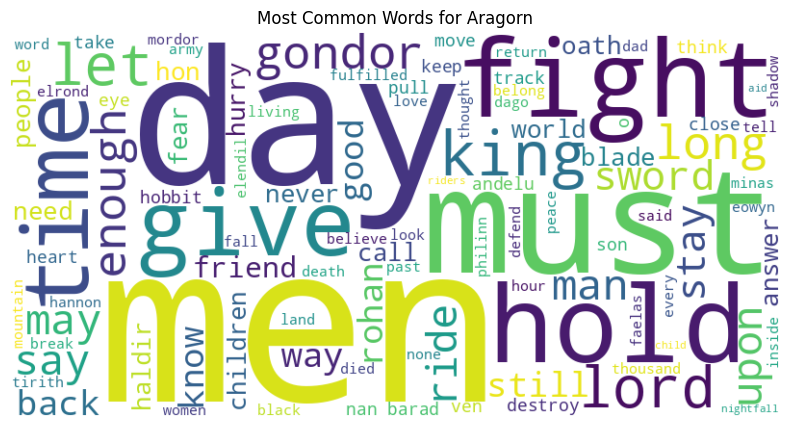

In [16]:
aragorn_dialog = " ".join(df_use[df_use['char'] == 'ARAGORN']['dialog_clean'])

# Define stopwords (words to ignore)
my_stopwords = set(STOPWORDS)
my_stopwords.update([
    'frodo', 'mr', 'gandalf', 'sam', 'aragorn', 'pippin', 'merry', 'gollum', 'strider', 'samwise', 'smeagol', 'bilbo', 'sauron', 'saruman', 'legolas', 'gimli', # Character names
    'one', 'ring', 'will', 'now', 'dont', 'get', 'go', 'im', 'ive', 'ill' # Common filler words
    'well', 'us', 'oh', 'yes', 'no', 'come', 'hes', 'got', 'theres', # More filler
    'two', 'three', 'four', 'five', 'six', 'seven', 'eight', # numbers
    'le', 'brego' #elvish
])

# Generate the word cloud object
aragorn_wc = WordCloud(
    stopwords=my_stopwords,
    background_color='white',
    width=800,
    height=400,
    max_words=100 # Show the top 100 words
).generate(aragorn_dialog)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(aragorn_wc, interpolation='bilinear')
plt.axis('off') # Hide the X and Y axes
plt.title('Most Common Words for Aragorn')
plt.show()

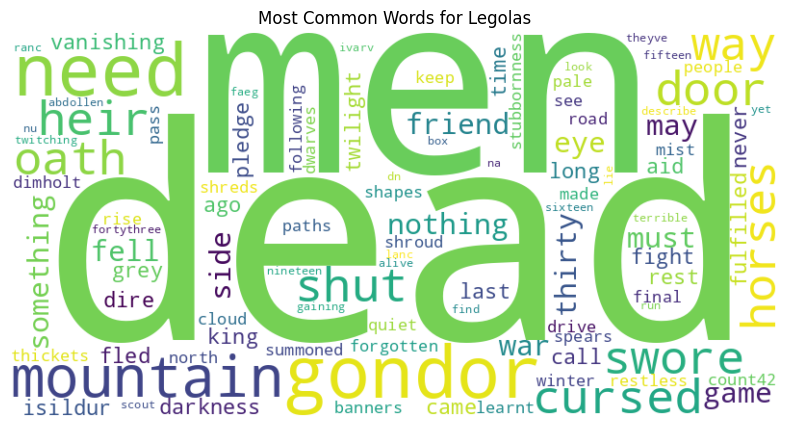

In [17]:
legolas_dialog = " ".join(df_use[df_use['char'] == 'LEGOLAS']['dialog_clean'])

# Define stopwords (words to ignore)
my_stopwords = set(STOPWORDS)
my_stopwords.update([
    'frodo', 'mr', 'gandalf', 'sam', 'aragorn', 'pippin', 'merry', 'gollum', 'strider', 'samwise', 'smeagol', 'bilbo', 'sauron', 'saruman', 'legolas', 'gimli', # Character names
    'one', 'ring', 'will', 'now', 'dont', 'get', 'go', 'im', 'ive', 'ill' # Common filler words
    'well', 'us', 'oh', 'yes', 'no', 'come', 'hes', 'got', 'theres', # More filler
    'two', 'three', 'four', 'five', 'six', 'seven', 'eight', # numbers
    'le', 'brego' #elvish
])

# Generate the word cloud object
legolas_wc = WordCloud(
    stopwords=my_stopwords,
    background_color='white',
    width=800,
    height=400,
    max_words=100 # Show the top 100 words
).generate(legolas_dialog)

# Plot the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(legolas_wc, interpolation='bilinear')
plt.axis('off') # Hide the X and Y axes
plt.title('Most Common Words for Legolas')
plt.show()

### Word Counts by Character

This is important insight as characters with a very low word count will likely have a bias on their sentiment based on the few words they say so we may want to exclude these from the modelling. Likewise a low word count may indicate 'extras' that we wouldn't want including in our analysis.

In [18]:
# total word count by character

char_word_counts = df_use.groupby('char')['word_count'].sum().sort_values(ascending=False).to_frame(name='total_words')

print(char_word_counts.head(25))

           total_words
char                  
GANDALF           3363
SAM               2115
FRODO             1756
ARAGORN           1712
GOLLUM            1300
THEODEN           1208
PIPPIN            1090
BILBO             1081
GIMLI              996
MERRY              867
FARAMIR            808
DENETHOR           803
SARUMAN            662
TREEBEARD          654
ELROND             636
GALADRIEL          556
EOWYN              494
LEGOLAS            479
BOROMIR            474
EOMER              406
ARWEN              394
GRIMA              376
SMEAGOL            374
ORC                235
SOLDIER            186


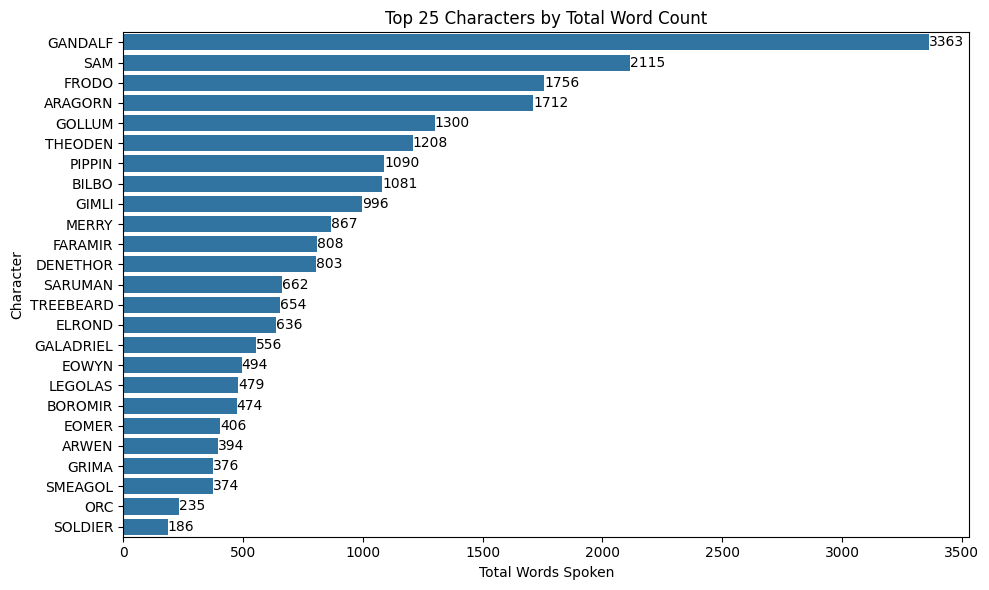

In [19]:
# Plotting a barplot of the top 25 characters who say the most words across the trilogy

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y=char_word_counts.index[:25],
    x=char_word_counts['total_words'][:25],
    orient='h'
)
ax.bar_label(ax.containers[0],fmt='%d')
plt.title('Top 25 Characters by Total Word Count')
plt.xlabel('Total Words Spoken')
plt.ylabel('Character')
plt.tight_layout()



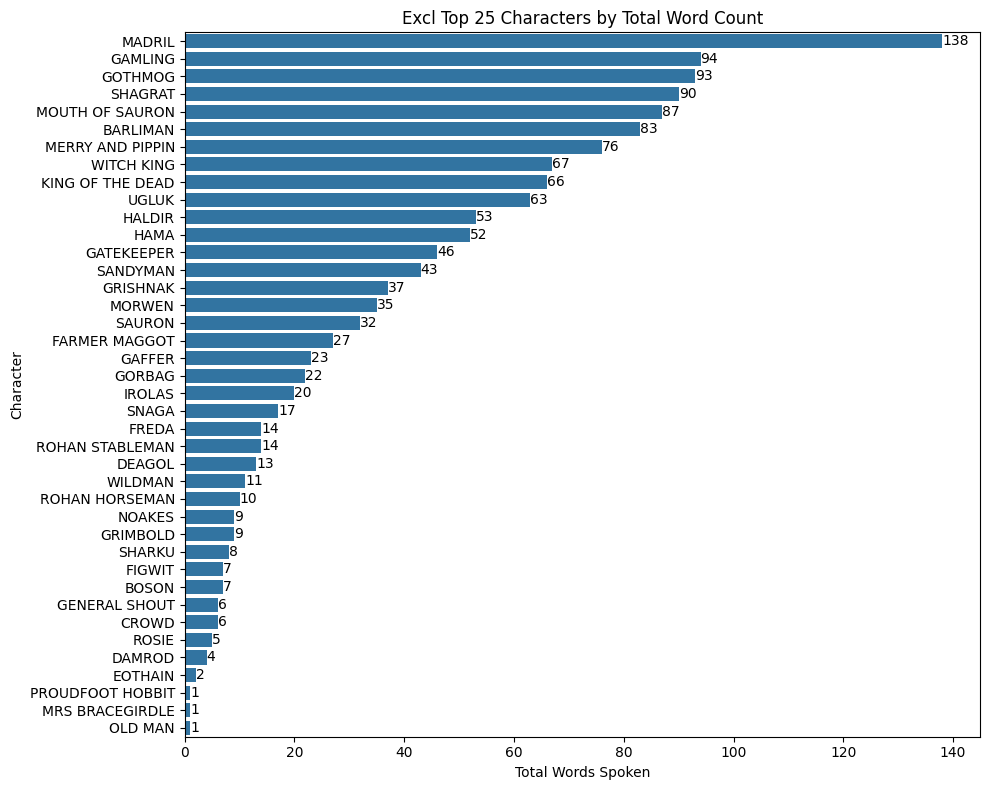

In [20]:
# Plotting a bar plot for the rest of the characters

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    y=char_word_counts.index[25:],
    x=char_word_counts['total_words'][25:],
    orient='h'
)
ax.bar_label(ax.containers[0],fmt='%d')
plt.title('Excl Top 25 Characters by Total Word Count')
plt.xlabel('Total Words Spoken')
plt.ylabel('Character')
plt.tight_layout()

Made the decision to carry on with anyone who's said more than 30 words so we can include Sauron (big character but low word count)

### Sentiment Analysis by Character

(<matplotlib.lines.Line2D at 0x7a98c69aa960>,)

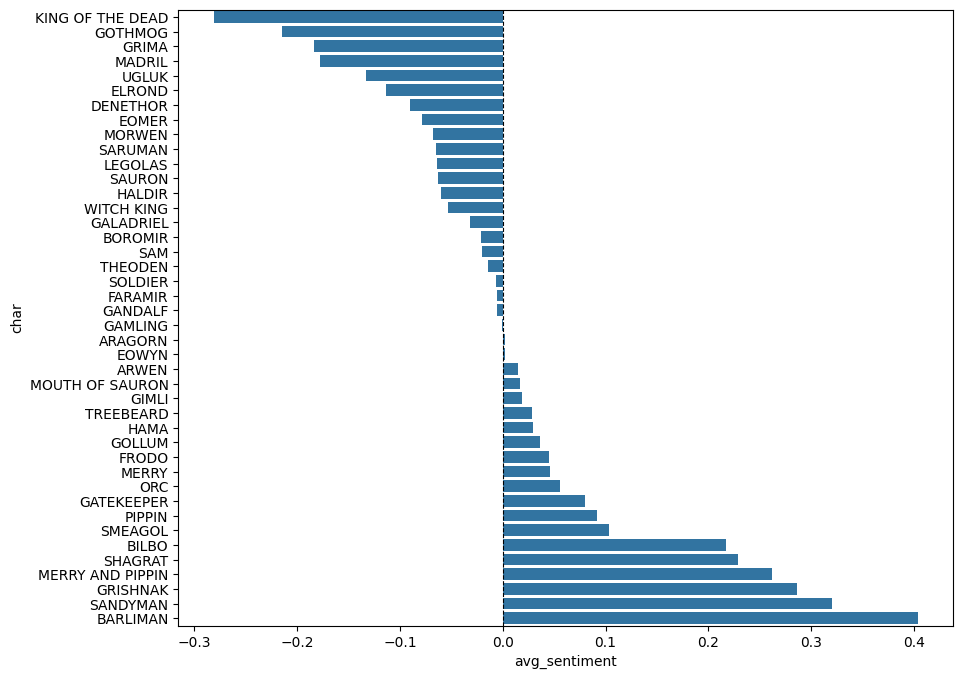

In [21]:
# plotting avg sentiment by character

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    y=filtered_sentiment_analysis.index,
    x=filtered_sentiment_analysis['avg_sentiment'],
)

plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8),


In [22]:
# show most positive lines

most_positive_lines = df_use.sort_values(by='sentiment', ascending=False)

print(most_positive_lines[['char', 'dialog', 'sentiment']].head(10))

         char                                             dialog  sentiment
2021    BILBO   Frodo, someone at     the door. ,In fact, it ...     0.9935
261     MERRY  My lady. You are fair and brave and have much ...     0.9766
2340    BILBO  I know, he'd probably come with me if I asked ...     0.9695
415    GOLLUM  Sneaking?  Sneaking?  Fat Hobbit is always so ...     0.9651
1970  GANDALF  It was more than mere chance thatbrought Merry...     0.9356
1113   GOLLUM      Yeees! , Yeees!    , Precious! My Precious...     0.9321
2174    BILBO  Alas, elevnty-one years is far too short a tim...     0.9246
776    GOLLUM  The rock and pool    Is nice and cool    So ju...     0.9240
173     EOWYN          Courage Merry. Courage for our friends.       0.9186
247   SMEAGOL  It wasn't us. It wasn't us. ,Smeagol wouldn't ...     0.9131


In [23]:
# show most negative lines

most_negative_lines = df_use.sort_values(by='sentiment', ascending=True)

print(most_negative_lines[['char', 'dialog', 'sentiment']].head(10))

                  char                                             dialog  \
2035            GOLLUM  Too risky. Too risky. ,Thieves. They stole it ...   
342              EOMER  You know as little of war as that Hobbit.   Wh...   
496             GOLLUM  Master betrayed us. Wicked. Tricksy. False. ,W...   
986            FARAMIR  The enemy? ,His sense of duty was no lessthan ...   
2199            GOLLUM  Never! Smeagol wouldn't hurt a fly! ,     Aaaa...   
288   KING OF THE DEAD  The way is shut! It was made by those who are ...   
128         WITCH KING           You fool!  No man can kill me.  Die now!   
1284            GOLLUM  Oh, cruel Hobbit.It does not care if we be hun...   
1858         GALADRIEL  For within these rings was bound the strength ...   
1043           GANDALF  This is but a taste of the terror that Saruman...   

      sentiment  
2035    -0.9694  
342     -0.9675  
496     -0.9661  
986     -0.9432  
2199    -0.9431  
288     -0.9369  
128     -0.9358  
1284    

Fascinating! Although not entirely useful as this has assessed the words themselves, not the context that they're said in.
VaDER can't understand sarcasm;
- Gollum talking about Sam being mean to him is actually not positive: line 415
- Grishnak 'Go on, call for help' & 'they look tasty' is actually not positive!
- Gollum and Smeagol repeatedly refer to 'the precious' which it's picked up as positive.
- Talks of war score negatively but are a key feature of the film.

The average sentiment is based on the law of averages - those with 1 or 2 lines of script are likely to be on one extreme or the other (positive or negative) but idea is that the average sentiment is deduced through many lines of dialogue (exactly why I removed those on really low numbers)


In [24]:
char_sentiment = df_use.groupby('char')['sentiment'].mean().to_frame(name='avg_sentiment')

df_grouped = df_use.groupby(['char', 'movie'])['word_count'].sum().reset_index()

#pivot it to get a number of words per character per film
df_pivot = df_grouped.pivot(index='char', columns='movie', values='word_count').fillna(0)

#merge into one dataframe
df_features = df_pivot.merge(char_sentiment_analysis, left_index=True, right_index=True)

#Filter to just those with more than 30 words
df_features['total_words'] = df_features['The Fellowship of the Ring'] + df_features['The Two Towers'] + df_features['The Return of the King']

df_cluster = df_features[df_features['total_words'] > 30].copy()

print(df_cluster)

                  The Fellowship of the Ring  The Return of the King  \
char                                                                   
ARAGORN                                443.0                   580.0   
ARWEN                                  178.0                   106.0   
BARLIMAN                                83.0                     0.0   
BILBO                                 1023.0                    58.0   
BOROMIR                                337.0                     0.0   
DENETHOR                                 0.0                   556.0   
ELROND                                 185.0                   252.0   
EOMER                                    0.0                   166.0   
EOWYN                                    0.0                   252.0   
FARAMIR                                  0.0                   337.0   
FRODO                                  467.0                   674.0   
GALADRIEL                              471.0                    

### Sentiment Analysis by Film

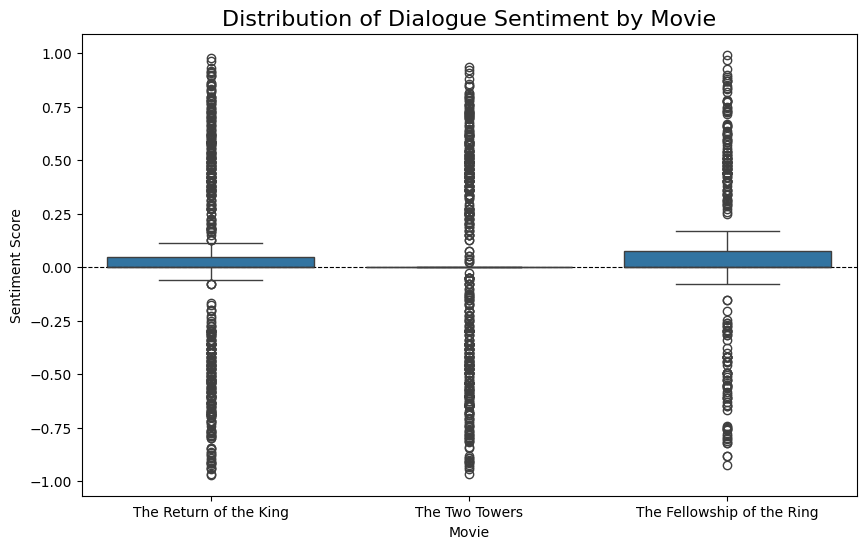

In [25]:
# Creating sentiment by movie boxplot

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_use,
    x='movie',
    y='sentiment'
)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8) # Add neutral line
plt.title('Distribution of Dialogue Sentiment by Movie', fontsize=16)
plt.xlabel('Movie')
plt.ylabel('Sentiment Score')
plt.show()

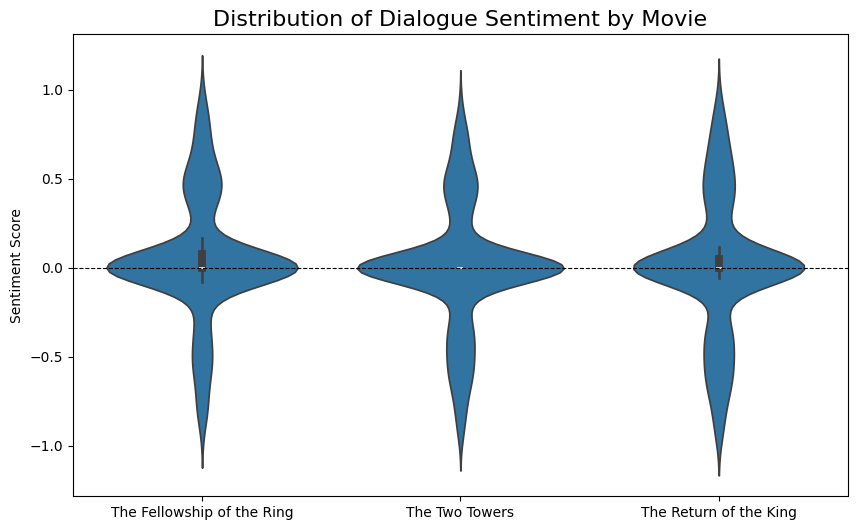

In [26]:
# Trying a violin plot as this is a bit hard to see - that's good though.
# Most of the films dialogue likely neutral ("he went that way", "yes", "What is it?") with the outliers being the positive and negative sentiments we're interested in

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_use,
    x='movie',
    y='sentiment',
    order=('The Fellowship of the Ring', 'The Two Towers', 'The Return of the King')
)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8) # Add neutral line
plt.title('Distribution of Dialogue Sentiment by Movie', fontsize=16)
plt.xlabel('')
plt.ylabel('Sentiment Score')
plt.show()

This supports this idea - large volume of c.-/+0.2 sentiment

### Character Sentiment by Total Word count

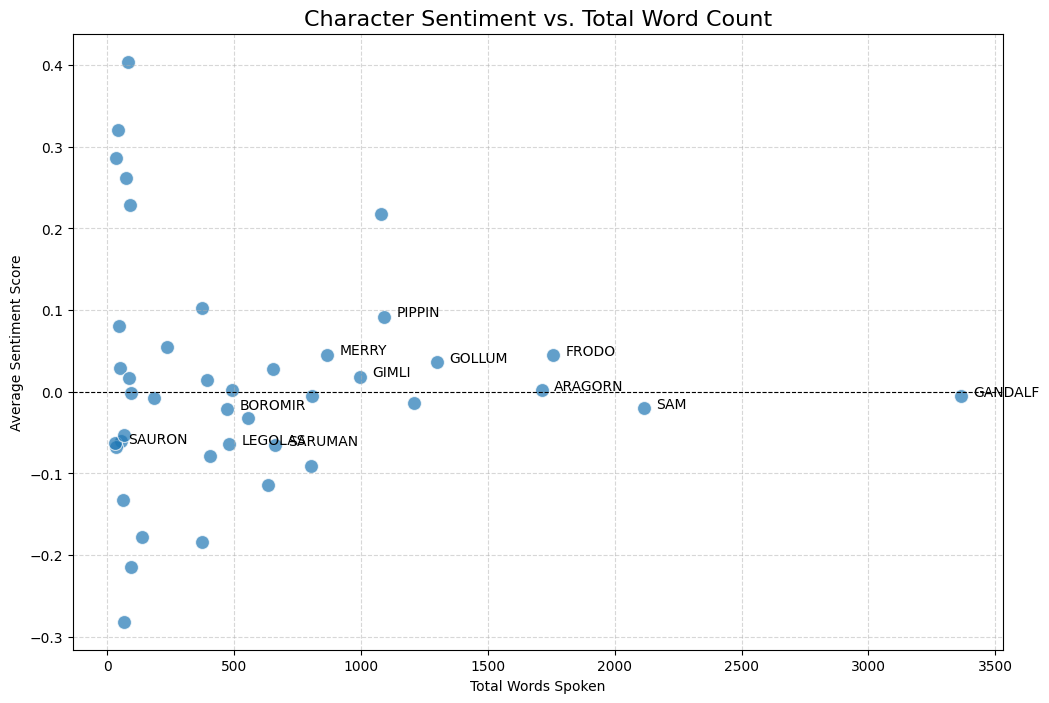

In [27]:

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_cluster,
    x='total_words',
    y='avg_sentiment',
    s=100, # Make the dots bigger
    alpha=0.7
)

# Add a neutral line
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Add labels for key characters

characters_to_label = ['GANDALF', 'ARAGORN', 'SAM', 'FRODO', 'GOLLUM', 'SARUMAN', 'BOROMIR', 'LEGOLAS', 'GIMLI', 'SAURON', 'MERRY', 'PIPPIN']

# Loop through and add text
for char_name in characters_to_label:
    if char_name in df_cluster.index:
        plt.text(
            x=df_cluster.loc[char_name]['total_words'] + 50, # Small offset
            y=df_cluster.loc[char_name]['avg_sentiment'],
            s=char_name
        )

plt.title('Character Sentiment vs. Total Word Count', fontsize=16)
plt.xlabel('Total Words Spoken')
plt.ylabel('Average Sentiment Score')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Correlation Map of Model Variables

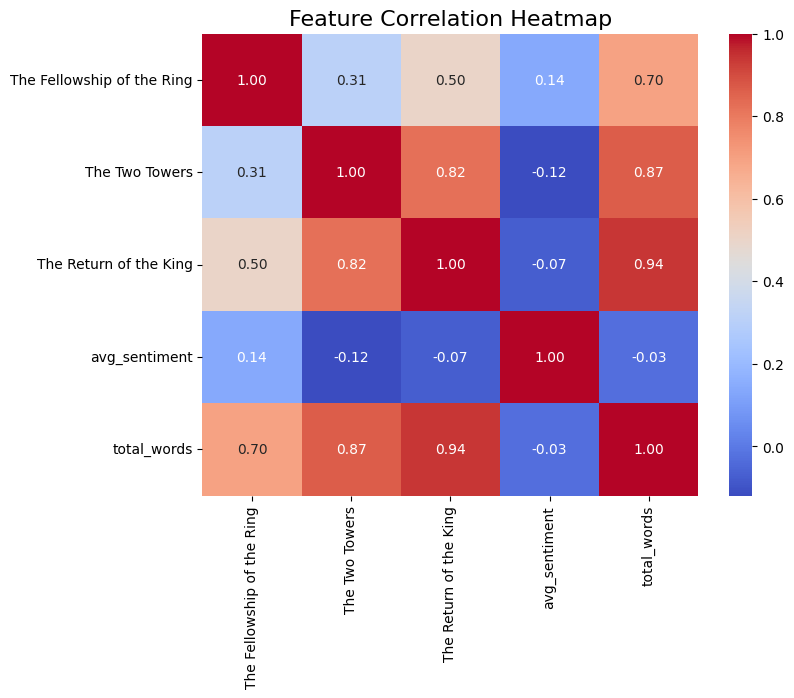

In [28]:
# Select only the 4 features & total_words
features_for_heatmap = ['The Fellowship of the Ring', 'The Two Towers', 'The Return of the King', 'avg_sentiment', 'total_words']
heatmap_data = df_cluster[features_for_heatmap]

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data.corr(), # Calculate the correlation matrix
    annot=True,          # Show the numbers in the squares
    cmap='coolwarm',     # Use a blue-to-red color map
    fmt='.2f'            # Format numbers to 2 decimal places
)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

Avg Sentiment is not strongly correlated with anything which is good & an independent feature for the model!
TROK and TTT being highly correlated isn't an issue. K-means is a distance based algorithm so doesn't mind things being correlated. Regressions though would have an issue as a regression cant tell the difference between correlated variables impact on the output, so makes the 'holding all other variables constant' part very hard to do

## Modelling

In [29]:
#Scaling for k-Means as a distance based algorithm

features_to_scale = ['The Fellowship of the Ring', 'The Two Towers', 'The Return of the King', 'avg_sentiment']
scaler = StandardScaler()

data_scaled = scaler.fit_transform(df_cluster[features_to_scale])

df_cluster[features_to_scale].head()


,The Fellowship of the Ring,The Two Towers,The Return of the King,avg_sentiment
char,,,,
ARAGORN,443.0,689.0,580.0,0.001752
ARWEN,178.0,110.0,106.0,0.014440
BARLIMAN,83.0,0.0,0.0,0.404025
BILBO,1023.0,0.0,58.0,0.217094
BOROMIR,337.0,137.0,0.0,-0.021285


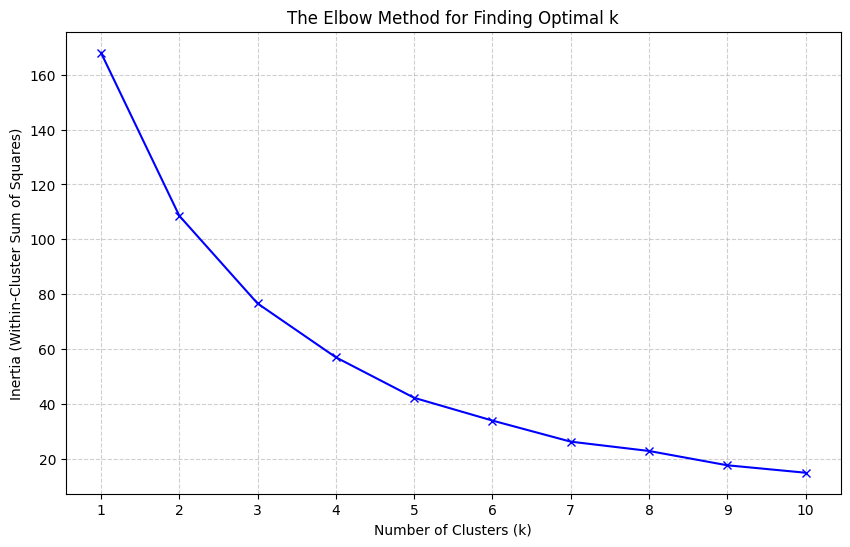

In [30]:
# Create an empty list to store the inertia values
inertia_list = []

# Define the range of k values to test
k_range = range(1, 11) # Test k from 1 to 10

# Loop through each k
for k in k_range:
    # Initialize the KMeans model
    kmeans = KMeans(
        n_clusters=k,       # The number of clusters to form
        init='k-means++',   # Selects initial cluster at random then picks the 2nd intelligently to speed up convergance and avoid poor results
        n_init=10,          # Run the algorithm 10 times and pick the best one
        random_state=42     # For reproducible results
    )

    # Fit the model to the scaled data
    kmeans.fit(data_scaled)

    # Add the model's inertia (the WCSS)
    inertia_list.append(kmeans.inertia_)


# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_list, 'bx-') # 'bx-' = blue line, 'x' markers
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('The Elbow Method for Finding Optimal k')
plt.xticks(k_range) # Show all k values on the x-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

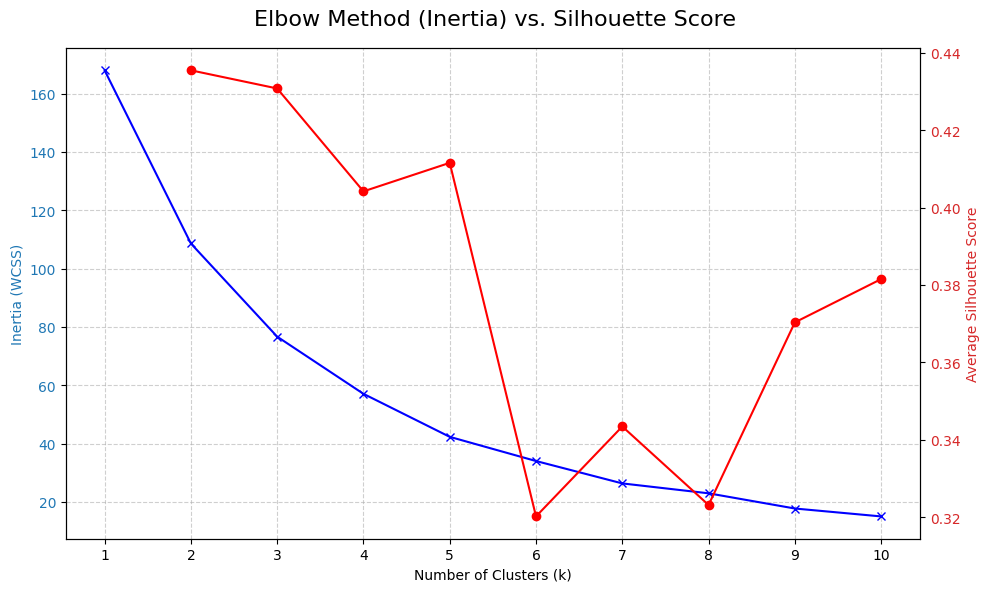

In [31]:
#Elbow method is useful, but want to add the silhouette score too to get a rounded picture

inertia_list = []
silhouette_scores = []
k_range_elbow = range(1, 11)
k_range_silhouette = range(2, 11)

for k in k_range_elbow:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    inertia_list.append(kmeans.inertia_)

for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    labels = kmeans.labels_
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

    # Create the figure and the first Y-axis (ax1)
fig, ax1 = plt.subplots(figsize=(10, 6))

    # First: Elbow Method (Left Axis, Blue)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (WCSS)', color=color)
ax1.plot(k_range_elbow, inertia_list, 'bx-', label='Inertia (Elbow)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

    # Second: Silhouette Score (Right Axis, Red)
    # Create the second Y-axis (ax2) that shares the same X-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Silhouette Score', color=color)
ax2.plot(k_range_silhouette, silhouette_scores, 'ro-', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Elbow Method (Inertia) vs. Silhouette Score', fontsize=16)
fig.tight_layout() # Make room for the y-labels

    # Add a single X-axis grid
ax1.set_xticks(k_range_elbow)
plt.show()

## Fit the model - 3 Clusters



         The Fellowship of the Ring  The Two Towers  The Return of the King  \
cluster                                                                       
0                        332.142857      701.142857              758.714286   
1                         64.655172      154.793103              133.172414   
2                        191.833333        6.333333               36.833333   

         avg_sentiment  total_words  
cluster                              
0             0.019301   1792.00000  
1            -0.045517    352.62069  
2             0.286466    235.00000  


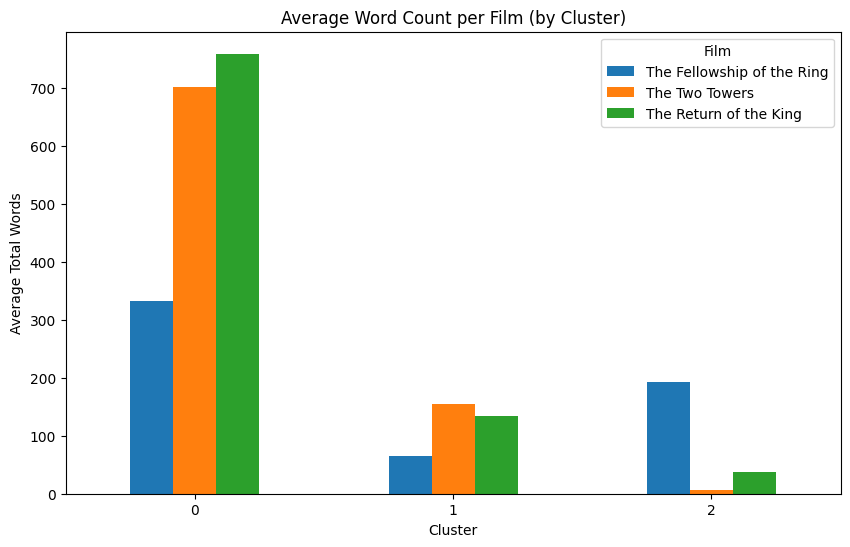

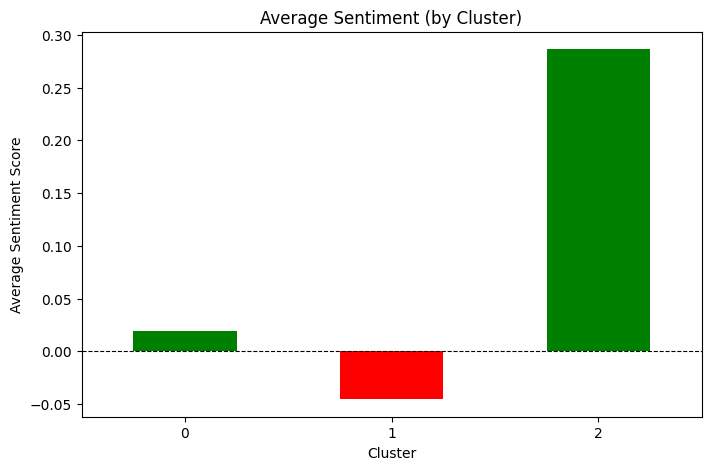

In [32]:
# fit the model based on K=3
# the elbow is generally quite smooth but an argument made for 3 or 4 so added the
# silhouette score which says on avg how distinct the clusters are
# gone with 3 as higher silhouette and decent elbow

k_optimal = 3
kmeans_final =  KMeans(
    n_clusters=k_optimal,
    init='k-means++',
    n_init=10,
    random_state=42
)

kmeans_final.fit(data_scaled)

#Get cluster labels for each character
cluster_labels = kmeans_final.labels_

#Add the labels to the datset as a new column
df_cluster['cluster'] = cluster_labels

# Analyze the Cluster Centroids
cluster_centroids = df_cluster.groupby('cluster').mean()

print(cluster_centroids[['The Fellowship of the Ring', 'The Two Towers', 'The Return of the King', 'avg_sentiment', 'total_words']])

# Plotting the 3 movie word counts
cluster_centroids[['The Fellowship of the Ring', 'The Two Towers', 'The Return of the King']].plot(
    kind='bar',
    figsize=(10, 6)
)
plt.title('Average Word Count per Film (by Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Average Total Words')
plt.xticks(rotation=0)
plt.legend(title='Film')
plt.show()

# Plotting the average sentiment
cluster_centroids['avg_sentiment'].plot(
    kind='bar',
    figsize=(8, 5),
    color=cluster_centroids['avg_sentiment'].apply(lambda x: 'green' if x > 0 else 'red')
)
plt.title('Average Sentiment (by Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment Score')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Add neutral line
plt.xticks(rotation=0)
plt.show()

Cluster 0 has a high word count in every film with a fairly average sentiment. I'm going to say these look like main characters across the trilogy that go through a lot of mixed events - some good and some bad, explaining the average sentiment being around 0. Cluster 1 has a pretty low average word count but a negative sentiment. I'm going to say these are the silent but violent types, low words, negative people, maybe key bad guys. The final Cluster 2 has a fairly high word count in the 1st film but then low to nil word count in film 2 and 3 with a very positive sentiment. I think these might be your single-arc characters who had so much promise but are the heartbreakers.



In [33]:


# Print the index (the character names) for each cluster
print("\n=== Cluster 0 ('Trilogy Mains'?) ===")
print(df_cluster[df_cluster['cluster'] == 0].index.tolist())

print("\n=== Cluster 1 ('Silent but Violent'?) ===")
print(df_cluster[df_cluster['cluster'] == 1].index.tolist())

print("\n=== Cluster 2 ('Single-Arc Heartbreakers'?) ===")
print(df_cluster[df_cluster['cluster'] == 2].index.tolist())


=== Cluster 0 ('Trilogy Mains'?) ===
['ARAGORN', 'FRODO', 'GANDALF', 'GOLLUM', 'PIPPIN', 'SAM', 'THEODEN']

=== Cluster 1 ('Silent but Violent'?) ===
['ARWEN', 'BOROMIR', 'DENETHOR', 'ELROND', 'EOMER', 'EOWYN', 'FARAMIR', 'GALADRIEL', 'GAMLING', 'GATEKEEPER', 'GIMLI', 'GOTHMOG', 'GRIMA', 'HALDIR', 'HAMA', 'KING OF THE DEAD', 'LEGOLAS', 'MADRIL', 'MERRY', 'MORWEN', 'MOUTH OF SAURON', 'ORC', 'SARUMAN', 'SAURON', 'SMEAGOL', 'SOLDIER', 'TREEBEARD', 'UGLUK', 'WITCH KING']

=== Cluster 2 ('Single-Arc Heartbreakers'?) ===
['BARLIMAN', 'BILBO', 'GRISHNAK', 'MERRY AND PIPPIN', 'SANDYMAN', 'SHAGRAT']


## Fit the model - 4 clusters


=== Cluster 0 ===
['ARAGORN', 'DENETHOR', 'FARAMIR', 'FRODO', 'GIMLI', 'GOLLUM', 'MERRY', 'PIPPIN', 'SAM', 'THEODEN', 'TREEBEARD']

=== Cluster 1 ===
['ARWEN', 'BOROMIR', 'ELROND', 'EOMER', 'EOWYN', 'GALADRIEL', 'GAMLING', 'GATEKEEPER', 'GOTHMOG', 'GRIMA', 'HALDIR', 'HAMA', 'KING OF THE DEAD', 'LEGOLAS', 'MADRIL', 'MORWEN', 'MOUTH OF SAURON', 'ORC', 'SARUMAN', 'SAURON', 'SMEAGOL', 'SOLDIER', 'UGLUK', 'WITCH KING']

=== Cluster 2 ===
['BARLIMAN', 'BILBO', 'GRISHNAK', 'MERRY AND PIPPIN', 'SANDYMAN', 'SHAGRAT']

=== Cluster 3 ===
['GANDALF']


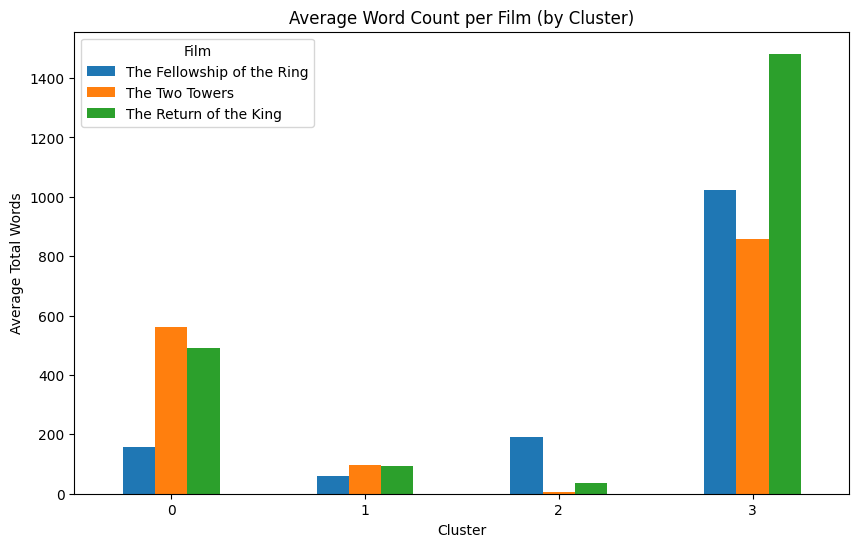

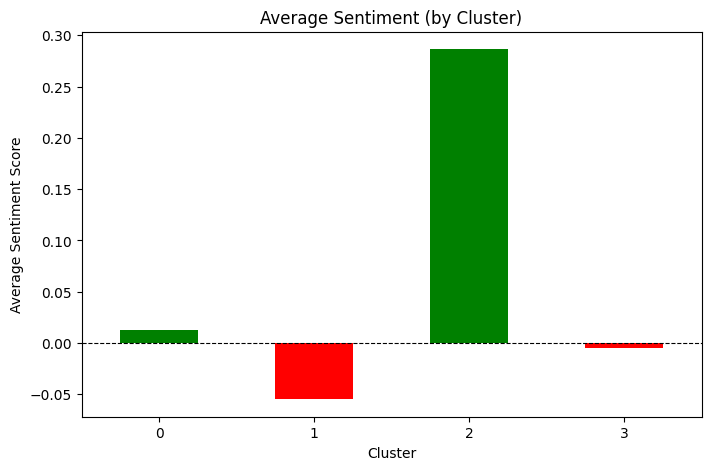

In [34]:
# Going to try with 4 and see what difference is

k_optimal = 4
kmeans_final_k4 = KMeans(
    n_clusters=k_optimal,
    init='k-means++',
    n_init=10,
    random_state=42
)

kmeans_final_k4.fit(data_scaled)

# Add labels to our DataFrame
df_cluster_k4 = df_cluster.copy()
df_cluster_k4['cluster'] = kmeans_final_k4.labels_

cluster_centroids_k4 = df_cluster_k4.groupby('cluster').mean()

pd.set_option('display.max_rows', None) # Show all names in the lists

# Loop from 0 to 3 to print each cluster's members
for k in range(k_optimal):
    print(f"\n=== Cluster {k} ===")
    print(df_cluster_k4[df_cluster_k4['cluster'] == k].index.tolist())    # .index.tolist() gets the character names

     # Plotting the 3 movie word counts
cluster_centroids_k4[['The Fellowship of the Ring', 'The Two Towers', 'The Return of the King']].plot(
    kind='bar',
    figsize=(10, 6)
)
plt.title('Average Word Count per Film (by Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Average Total Words')
plt.xticks(rotation=0)
plt.legend(title='Film')
plt.show()

# Plotting the average sentiment
cluster_centroids_k4['avg_sentiment'].plot(
    kind='bar',
    figsize=(8, 5),
    color=cluster_centroids_k4['avg_sentiment'].apply(lambda x: 'green' if x > 0 else 'red')
)
plt.title('Average Sentiment (by Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment Score')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Add neutral line on 0
plt.xticks(rotation=0)
plt.show()

/tmp/ipython-input-1403856503.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x=df_cluster_k4['pca_1'][i] + 0.03, # Small offset
/tmp/ipython-input-1403856503.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y=df_cluster_k4['pca_2'][i] + 0.03, # Small offset
/tmp/ipython-input-1403856503.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s=df_cluster_k4['character'][i],


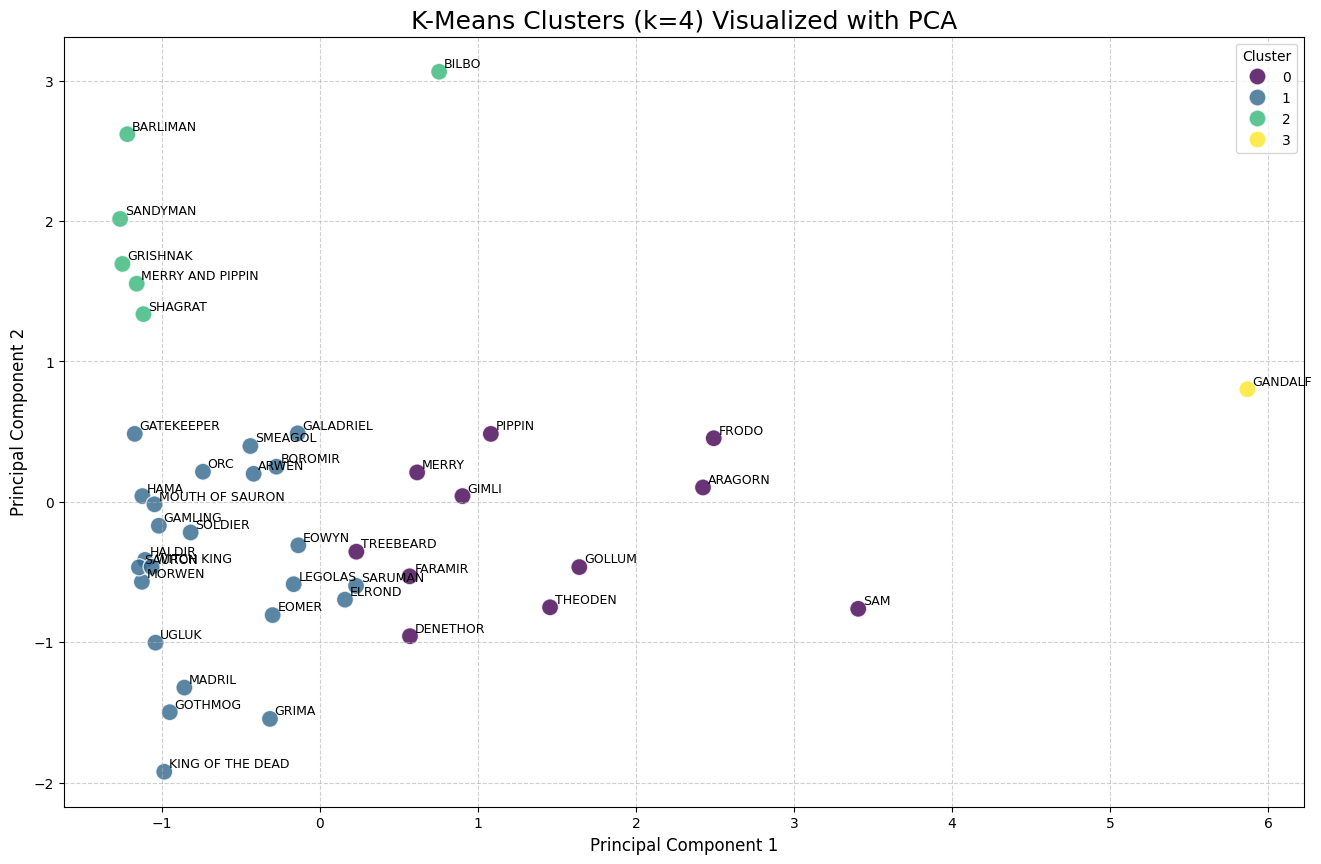

In [35]:

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

    # Add the PCA results to our DataFrame for easy plotting
df_cluster_k4['pca_1'] = data_pca[:, 0]
df_cluster_k4['pca_2'] = data_pca[:, 1]

    # Add the character names (which are the index) as a column
df_cluster_k4['character'] = df_cluster_k4.index


    # Plot the Cluster map
plt.figure(figsize=(16, 10))
sns.scatterplot(
      data=df_cluster_k4,
      x='pca_1',
      y='pca_2',
      hue='cluster',     # Color the dots by their cluster
      palette='viridis', # A nice color palette
      s=150,             # Make the dots bigger
      alpha=0.8
    )

    # Add the character name labels
for i in range(df_cluster_k4.shape[0]):
    plt.text(
        x=df_cluster_k4['pca_1'][i] + 0.03, # Small offset
        y=df_cluster_k4['pca_2'][i] + 0.03, # Small offset
        s=df_cluster_k4['character'][i],
        fontdict={'size': 9}
    )

plt.title('K-Means Clusters (k=4) Visualized with PCA', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Final: Interactive Plot, 4 clusters

Final position: there are, objectively, 4 main archetypes in The Lord of the Rings. These are visible in the below plot. Details of each character can be shown by hovering over the data point.

To answer the inital question, it would appear that there is 1 "main character" in the trilogy & that's Gandalf.

There's then a larger group of "main characters" (plural!) in the purple cluster. Blue and Green clusters are much smaller characters.

In [36]:

fig = px.scatter(
    df_cluster_k4,
    x='pca_1',
    y='pca_2',
    color='cluster',        # Color by cluster
    hover_name=df_cluster_k4.index, # Show character name as the title

    hover_data={
        # Format the axes to 2 decimal places
        'pca_1': ':.2f',
        'pca_2': ':.2f',

        # Format the feature data
        'avg_sentiment': ':.2f',  # to 2 dp
        'total_words': ':.0f',    # Format as a whole number
        'The Fellowship of the Ring': ':.0f',
        'The Two Towers': ':.0f',
        'The Return of the King': ':.0f'
    },

    title='K-Means Character Archetypes (k=4) via PCA'
)

# Set the marker size and opacity
fig.update_traces(marker=dict(size=12, opacity=0.8))

# Show the final plot
fig.show()